## <font color='darkblue'>Preface</font>
([source](https://towardsdatascience.com/time-series-outlier-detection-with-thymeboost-ec2046e17458)) <font size='3ptx'><b>Shrinking the impact of extreme points with boosting. All code lives here: ThymeBoost <a href='https://github.com/tblume1992/ThymeBoost'>Github</a></b></font>

<b>A common task when dealing with time series data is to identify and handle outliers</b>. It is important to be aware of these data points since they can have a large amount of influence on any analysis. There are many ways to identify and handle these data points, but today we will take a look at how you can manage them with <b><a href='https://github.com/tblume1992/ThymeBoost'>ThymeBoost</a></b>.

If this is the first time you are hearing about ThymeBoost, I encourage you to check out a <a href='https://towardsdatascience.com/thymeboost-a0529353bf34'>previous article</a> walking through the framework. At a bird’s eye view, <b>ThymeBoost takes traditional time series decomposition and combines it with gradient boosting. It attempts to take as many positives from each methodology as possible, while leaving behind many of the negative aspects</b>.

The package is under constant development so even if you have it installed there is a 100% chance that there is a new version on pip!

Before we get to the outlier handling, <b>a quick disclaimer: ThymeBoost is still early on in development so use at your own risk! Additionally, outlier detection is not the main focus of ThymeBoost, it is just a nice feature.</b> There exist many more-robust methods for outlier detection and handling.
With that, let’s get to the example…

### <font color='darkgreen'>Agenda</font>
* <font size='3ptx'><b><a href='#sect1'>A simple example</a></b></font>
* <font size='3ptx'><b><a href='#sect2'>Handling Outliers Using the Outlier Column</a></b></font>
* <font size='3ptx'><b><a href='#sect3'>Handling Outliers Using the Regularize Argument</a></b></font>

In [22]:
#!pip install ThymeBoost

<a id='sect1'></a>
## <font color='darkblue'>A simple example</font>
<font size='3ptx'><b>We will simulate a simple series composed of trend, seasonality, and little noise:</b></font>

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

#Here we will just create a random series with seasonality and a slight trend
seasonality = ((np.cos(np.arange(1, 101))*10 + 50))
np.random.seed(100)
true = np.linspace(-1, 1, 100)
noise = np.random.normal(0, 1, 100)

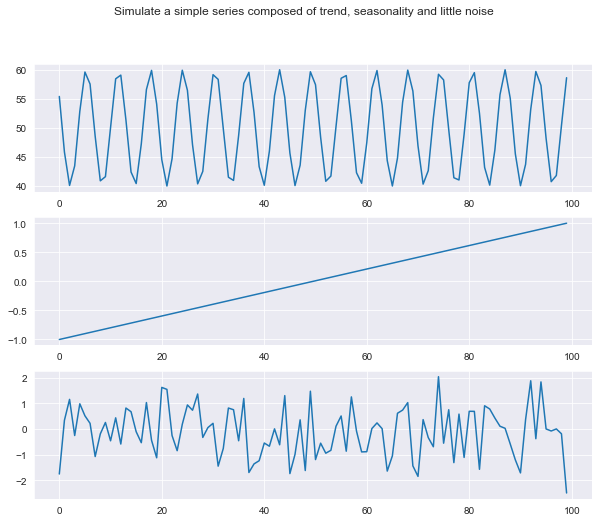

In [17]:
plt.rcParams['figure.figsize'] = [10, 8]
fig, axs = plt.subplots(3)
fig.suptitle('Simulate a simple series composed of trend, seasonality and little noise')
axs[0].plot(seasonality)
axs[1].plot(true)
axs[2].plot(noise)
plt.show()

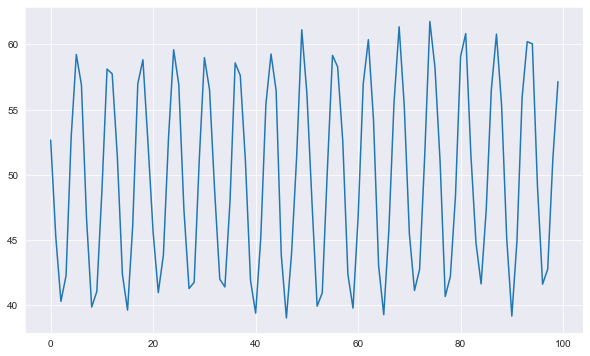

In [14]:
plt.rcParams['figure.figsize'] = [10, 6]
y = true + seasonality + noise
plt.plot(y)
plt.show()

The added noise gives a few points a bit more of a spike, but overall nothing sticks out too much here. <b>Let’s hand this data over to <a href='https://github.com/tblume1992/ThymeBoost'>ThymeBoost</a> to see what it thinks of the series.</b>

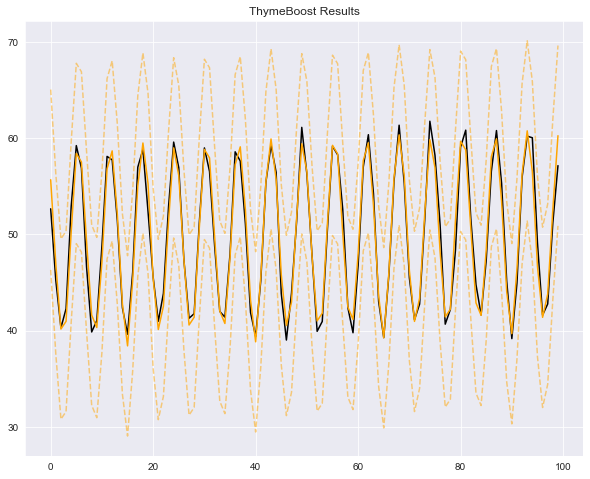

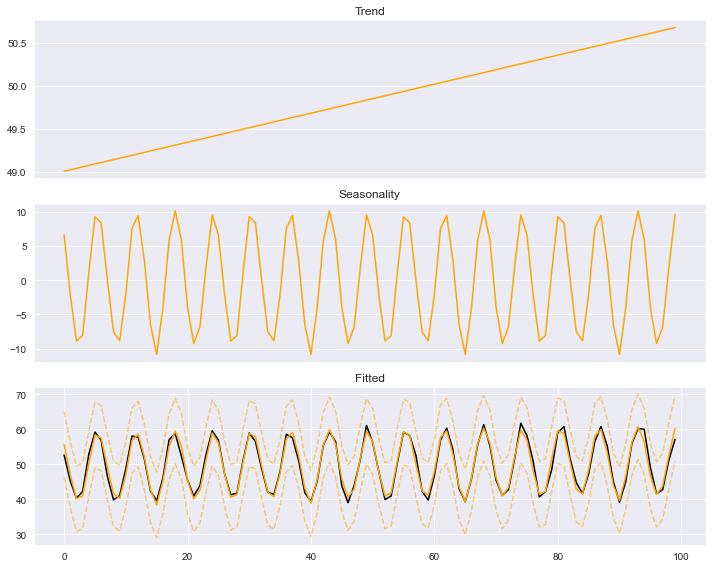

In [23]:
from ThymeBoost import ThymeBoost as tb
boosted_model = tb.ThymeBoost()
output = boosted_model.detect_outliers(
    y, trend_estimator='linear', seasonal_estimator='fourier',
    seasonal_period=25, global_cost='maicc', fit_type='global')

boosted_model.plot_results(output)
boosted_model.plot_components(output)

Here we use the ‘<font color='blue'>detect_outliers</font>’ method rather than a standard <font color='blue'>fit</font>. This method acts the same as the ‘<font color='blue'>fit</font>’ method except <b>it will test for points laying outside of the error bounds. These error bounds will only be consistent for simple linear trend estimators</b>. If you were to pass a smoother like ‘ses’ (<font color='brown'>simple exponential smoothing</font>) as the trend then these bounds will be quite wonky! Since we are using a simple linear trend we are safe to proceed and take a look at the `outliers` column the method added to the output DataFrame:

In [31]:
output.head(n=10)

,y,yhat,yhat_upper,yhat_lower,seasonality,trend,outliers
0,52.653258,55.670570,65.035036,46.306103,6.661716,49.008853,False
1,45.201414,46.921838,56.286305,37.557372,-2.103859,49.025697,False
2,40.293515,40.162373,49.526839,30.797907,-8.880167,49.042540,False
3,42.271734,40.966292,50.330758,31.601826,-8.093092,49.059384,False
4,52.898751,50.224507,59.588973,40.860041,1.148280,49.076227,False
5,59.216932,58.400281,67.764747,49.035815,9.307210,49.093071,False
6,56.881414,57.515428,66.879894,48.150961,8.405513,49.109914,False
7,46.616370,49.261905,58.626371,39.897439,0.135147,49.126758,False
8,39.860818,41.613635,50.978101,32.249169,-7.529966,49.143601,False
9,41.046104,40.321403,49.685870,30.956937,-8.839041,49.160445,False


It seems <b><a href='https://github.com/tblume1992/ThymeBoost'>ThymeBoost</a></b> agrees with our earlier observation: the series is quite well behaved and contains no outliers. Let’s add one!

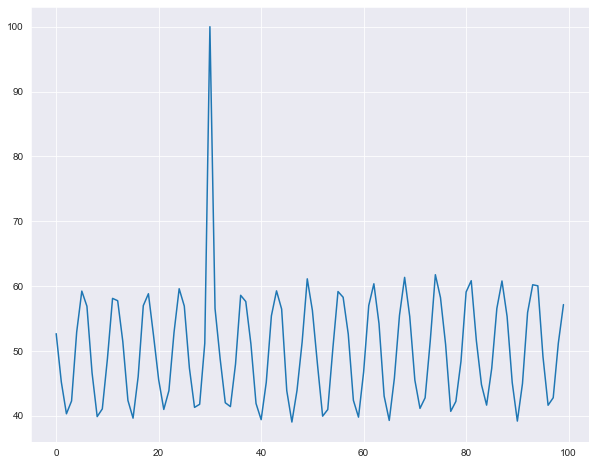

In [32]:
y[30] = 100
plt.plot(y)
plt.show()

Now that we have a clear outlier let’s see what happens when we give it to <b><a href='https://github.com/tblume1992/ThymeBoost'>ThymeBoost</a></b>.

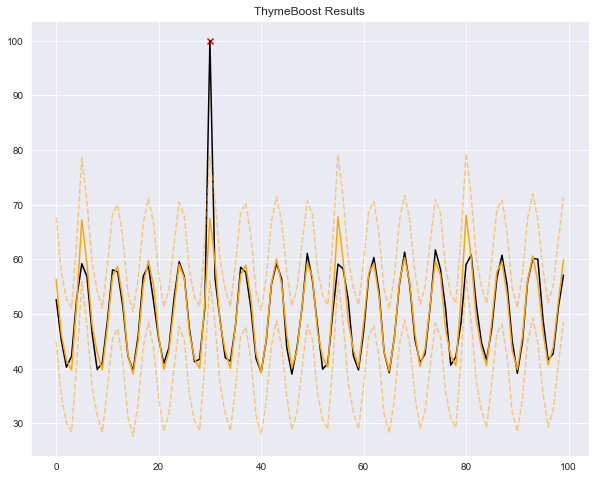

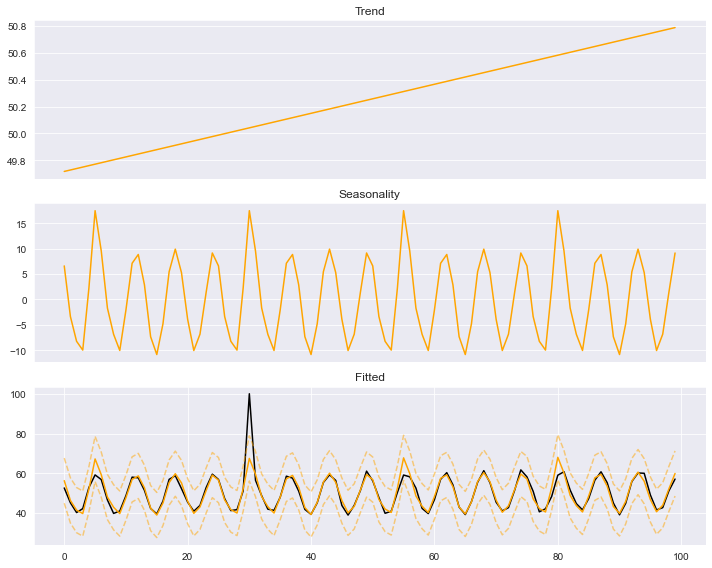

In [38]:
output_with_outlier = boosted_model.detect_outliers(
    y, trend_estimator='linear', seasonal_estimator='fourier',
    seasonal_period=25, global_cost='maicc', fit_type='global')

boosted_model.plot_results(output_with_outlier)
boosted_model.plot_components(output_with_outlier)

<b>The first thing to notice is that the `plot_results` plot now has a red ‘X’ where the outlier is</b>. If your output contains the outliers column then that will be used in the plotting. The next major observation is that our seasonal component is significantly altered by the presence of this outlier. The question is:

### <font color='darkgreen'>What do we do now?</font>
As mentioned previously, there are numerous ways to proceed. You may want to replace outliers with the mean of the series or the upper-bound of the fitted values or do nothing! <b>Let’s see some natural ways ThymeBoost can handle it</b>.

<a id='sect2'></a>
## <font color='darkblue'>Handling Outliers Using the Outlier Column</font>
We have a column of each observation tagged as either an outlier or not. Let’s use that to fix our seasonality:

In [34]:
output[output['outliers']==True]

,y,yhat,yhat_upper,yhat_lower,seasonality,trend,outliers
30,100.0,67.509933,78.855194,56.164672,17.46823,50.041703,True


In [36]:
weights = np.invert(output['outliers'].values) * 1
weights

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

All we do here is take our series and convert it to an array, flip the boolean with ‘invert’ and multiply by 1 to convert from True/False to 0/1 ints. The outcome is an array where the outlier data point is 0 and all other points are 1. With that in hand, we can do a normal fit but pass this array as the ‘<font color='violet'>seasonality_weights</font>’ argument which gives the outlier 0 influence when calculating seasonality. Note: These weights must be passed as an array and used with ‘fourier’ seasonality.

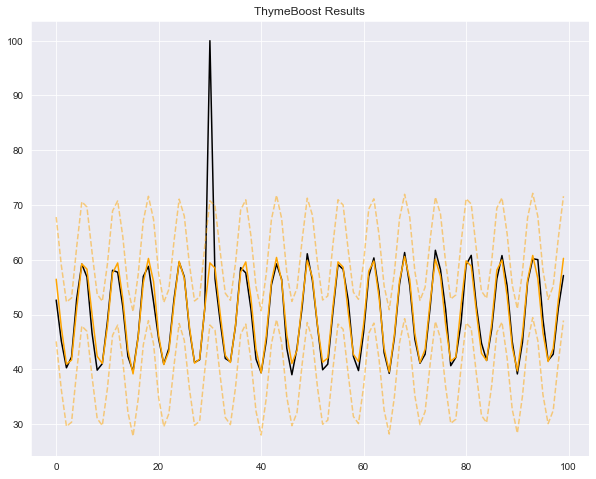

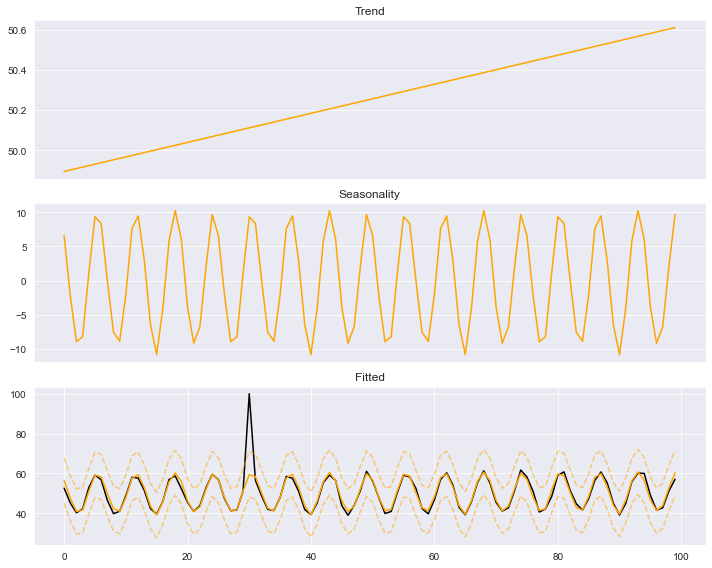

In [37]:
output = boosted_model.fit(
    y, trend_estimator='linear', seasonal_estimator='fourier',
    seasonal_period=25, global_cost='maicc', fit_type='global',
    seasonality_weights=weights)
boosted_model.plot_results(output)
boosted_model.plot_components(output)

Notice the red ‘X’ is now gone because we just used the standard `fit` method but now our seasonal component appears fixed. The large spike in our fitted seasonality, which was an artifact of the outlier, has been erased. This is even clearer when we take a look at those seasonal components:

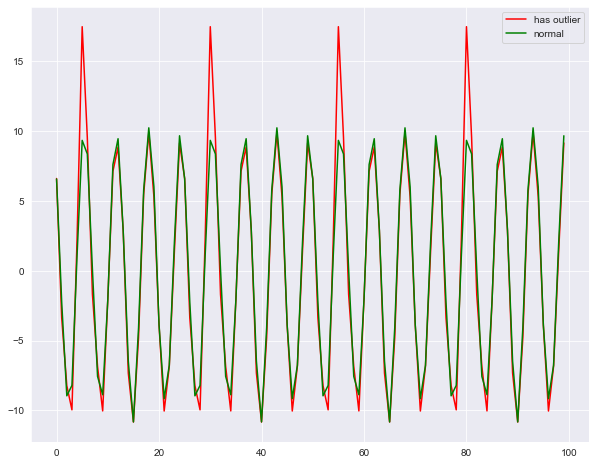

In [46]:
plt.plot(output_with_outlier['seasonality'], label='has outlier', c='r')
plt.plot(output['seasonality'], label='normal', c='g')
plt.legend()
plt.show()

We passed the weights as 0/1 however we could use any weights we want. But, these weights are still arbitrary. <b>What if we wanted weights that are dynamically assigned by how far away they are from ‘normal’?</b>

Is that possible? Yes, let’s take a look.

<a id='sect3'></a>
## <font color='darkblue'>Handling Outliers Using the Regularize Argument</font>
Instead of passing an array of weights we could alternatively <b>pass a string: ‘`regularize`’. ThymeBoost will now use a weighting scheme which will penalize higher error data points when approximating seasonality</b>. This weighting, combined with multiple rounds of boosting, provides a similar treatment as a <font size='3ptx'><b>I</b>teratively <b>R</b>eweighted <b>L</b>east <b>S</b>quares</font> method.

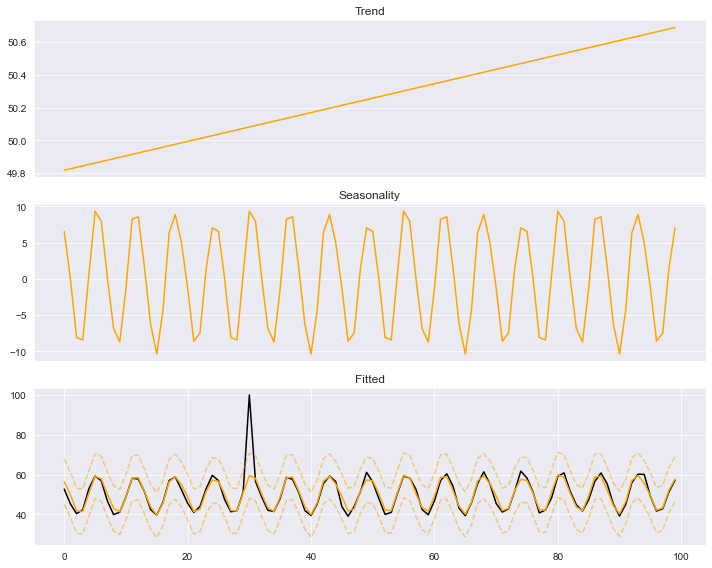

In [47]:
output = boosted_model.fit(
    y, trend_estimator='linear', seasonal_estimator='fourier',
    seasonal_period=25, global_cost='maicc', fit_type='global',
    seasonality_weights='regularize')

boosted_model.plot_components(output)

Once again, we see that the spikes have been cleansed from our approximated seasonal component. <b>This method can penalize points too much. In fact, if we take a closer look at this seasonal component that is exactly what happens in this case.</b>

## <font color='darkblue'>Conclusion</font>
<font size='3ptx'><b><a href='https://github.com/tblume1992/ThymeBoost'>ThymeBoost</a></b></font> <b>can detect and, quite naturally, handle outliers depending on their effect on our analysis</b>. In this example, the only real effect of the outlier was the seasonal component being altered which can be fixed by dealing with the seasonal component directly. As mentioned previously, there are other far more robust methods for detecting and dealing with outliers. You may even want to do nothing to outliers! There really is no simple answer, but hopefully ThymeBoost can provide useful insights.

<b>Another Disclaimer</b>: this package is still in early development. The sheer number of possible configurations makes debugging an involved procedure, so use at your own risk. But please, play around and open any issues you encounter on GitHub!